# Necessary Imports and Seed

In [1]:
# Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import scipy
import os
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
from tqdm.auto import tqdm
import timm

In [2]:
# Fixing the random seed to reproduce results
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
set_seed(42)

# Dataset Visualization and Pre-Processing

In [4]:
# Reading the labels
train_csv = pd.read_csv('/kaggle/input/ai-of-god-v20/train.csv')
test_csv = pd.read_csv('/kaggle/input/ai-of-god-v20/test.csv')
sample_submission = pd.read_csv('/kaggle/input/ai-of-god-v20/sample_submission.csv')

In [5]:
train_csv

,FileName,Class
0,1.jpg,0
1,2.jpg,0
2,3.jpg,0
3,4.jpg,0
4,5.jpg,0
...,...,...
8196,8197.jpg,0
8197,8198.jpg,0
8198,8199.jpg,0
8199,8200.jpg,0


In [6]:
test_csv

,FileName
0,1.jpg
1,2.jpg
2,3.jpg
3,4.jpg
4,5.jpg
...,...
2689,2690.jpg
2690,2691.jpg
2691,2692.jpg
2692,2693.jpg


In [7]:
sample_submission

,FileName,Class
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
...,...,...
2689,2690.jpg,1
2690,2691.jpg,1
2691,2692.jpg,1
2692,2693.jpg,1


Opening an image

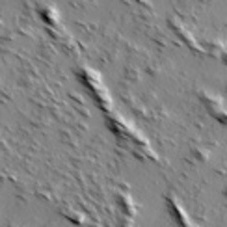

In [8]:
Image.open('/kaggle/input/ai-of-god-v20/train/3420.jpg')

Applying basic data augmentations to prepare the input for the model. Further this block can be used to introduce Data Augmentations such as flipping, random crop, rotation, etc. Refer to the documentation of albumentations library for more data augmentations.

In [9]:
transform = A.Compose(
    [
        A.Resize(256,256),
        A.CenterCrop(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        ToTensorV2()
    ]
)

Preparing the dataset class

In [10]:
class TrainData(Dataset):
    def __init__(self,transform=None):
        self.dir = "/kaggle/input/ai-of-god-v20/train/"
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.dir))
    
    def __getitem__(self,idx):
        img = cv2.imread(self.dir+str(idx+1)+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            img = self.transform(image=img)
        dic = {'image': img['image'],'label':train_csv['Class'][idx]}
        return dic

class TestData(Dataset):
    def __init__(self,transform=None):
        self.dir = "/kaggle/input/ai-of-god-v20/test/"
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.dir))
    
    def __getitem__(self,idx):
        img = cv2.imread(self.dir+str(idx+1)+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            img = self.transform(image=img)
        dic = {'image':img['image']}
        return dic

Creating an object of the dataset class and splitting the dataset into training and validation datasets. Here we will use the 90% of the data to train the model and the other 10% to evaluate the model.

In [11]:
# Set the split ratio
dataset = TrainData(transform=transform)

train_ratio = 0.9
validation_ratio = 0.1

# Calculate the sizes for each set
total_size = len(dataset)
train_size = int(train_ratio * total_size)
validation_size = total_size - train_size

# Use random_split to create training and validation datasets
train_data, valid_data = random_split(dataset, [train_size, validation_size])

In [12]:
len(dataset)

8201

In [13]:
df=pd.DataFrame()
filename=[]
labels=[]
for i in range (len(valid_data)):
    filename.append(valid_data[i]['image'])
    labels.append(valid_data[i]['label'])
# # label
# df['Filename']=filename
# df['label']=label
# df
len(labels)

821

Oversampling of data

In [14]:
labels_num = train_csv.sort_values(['Class'], ascending = False)
labels_num = labels_num.iloc[0,1]
labels_num = labels_num+1
labels_num

8

In [15]:
class_num = [0] * labels_num
for i in range (len(train_data)):
    class_num[train_data[i]['label']] +=1 

In [16]:
class_weights = []
for i in range(labels_num):
    class_weights.append(1/class_num[i])
class_weights

[0.00023073373327180433,
 0.000794912559618442,
 0.00390625,
 0.0024875621890547263,
 0.0013850415512465374,
 0.016129032258064516,
 0.0037174721189591076,
 0.012987012987012988]

In [17]:
sample_weights = [0] *len(train_data)
for idx in range(len(train_data)):
        sample_weights[idx] = class_weights[train_data[idx]['label']]

In [18]:
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Defining the model

With the CFG class, you can set the model you want to use, the number of labels (in our case we have 8 labels), batch size for mini batch gradient descent, number of epochs, number of workers, and the learning rate.

In [19]:
class CFG:
    model_name = 'efficientnet_b4'
    target_size = 8
    batch_size = 16
    epochs = 20
    num_workers = 2 if torch.cuda.is_available() else 4
    lr = 1e-5

 Here we have used ResNet18 as the sample model. You can explore other models as well to improve upon your results. Based on the CFG class we have defined the CustomNet model class.

In [20]:
class CustomNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained, num_classes=CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
from sklearn.metrics import f1_score

# Defining the functions for training, validation, and generating the labels on the test data respectively. The training and validation functions act on one epoch.

In [22]:
def train_fn(train_loader, model, optimizer, criterion, device):
    model.to(device).train()
    epoch_loss = 0
    count = 0
    
    for i, data in enumerate(tqdm(train_loader,total = len(train_loader))):
        images = data['image'].to(device)
        label = data['label'].to(device)

        output = model(images)
#         print(output.shape)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()*images.shape[0]
        count += images.shape[0]
        
    return epoch_loss/count
        

def valid_fn(valid_loader, model, criterion, device):
    model.to(device).eval()
    
    loss = 0
    count = 0
    preds=[]
    for i, data in enumerate(tqdm(valid_loader,total = len(valid_loader))):
        images = data['image'].to(device)
        label = data['label'].to(device)
        
        with torch.no_grad():
            output = model(images)
            step_loss = criterion(output, label)
            loss += step_loss.item()*images.shape[0]
            count += images.shape[0]
#             output=nn.Softmax(dim=1)(output)
#             output=torch.argmax(output,dim=1).to('cpu').numpy()
#             preds.append(output)
            preds.append(output.softmax(1).to('cpu').numpy())
#             print(len(preds))
#             preds.append(output.softmax(1).to('cpu').numpy())
#     preds = np.concatenate(preds)
#     preds = preds.argmax(1)    
#             print(output.shape,label.shape)
#             acc+=torch.sum(output==label)
#    
    preds = np.concatenate(preds)
    preds = preds.argmax(1)
    print(len(labels),len(preds))
    f11=f1_score(labels,preds, average='macro')
    return f11,loss/count
    

def test_fn(test_loader, model, device):
    model.to(device).eval()
    
    predictions = []
    for i, data in enumerate(tqdm(test_loader,total = len(test_loader))):
        images = data['image'].to(device)
        
        with torch.no_grad():
            output = model(images)
            predictions.append(output.softmax(1).to('cpu').numpy())
            
    predictions = np.concatenate(predictions)
    predictions = predictions.argmax(1)
    
    return predictions   

# Preparing the dataloaders and defining the loss function and optimizers

In [23]:
train_data

In [24]:
train_loader = DataLoader(train_data, batch_size=CFG.batch_size, sampler=sampler, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=CFG.batch_size, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [25]:
model = CustomNet(model_name=CFG.model_name, pretrained=True)

model.to(device)
epochs = CFG.epochs
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
criterion = nn.CrossEntropyLoss()

# The Training Loop

Here we run the training loop and save the best possible model

In [26]:
best_val_loss = np.inf
best_acc=0
for epoch in range(CFG.epochs):
    train_loss = train_fn(train_loader, model, optimizer, criterion, device)
    acc,val_loss = valid_fn(valid_loader, model, criterion, device)

    if val_loss < best_val_loss and acc>best_acc:
        print('Loss Improved')
        best_val_loss = val_loss
        print('accuracy Improved')
        best_acc=acc
        print(f'Epoch {epoch+1} - Save Val_Loss: {best_val_loss:.4f}')
        print(f'Epoch {epoch+1} - Save accuracy: {best_acc:.4f}')
        torch.save({'model': model.state_dict(), 
                    'optimizer': optimizer.state_dict()},
                    './'+f'{CFG.model_name}_best.pth')
    else :
        print(val_loss , acc)

  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
Loss Improved
accuracy Improved
Epoch 1 - Save Val_Loss: 0.4740
Epoch 1 - Save accuracy: 0.7639


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
Loss Improved
accuracy Improved
Epoch 2 - Save Val_Loss: 0.2390
Epoch 2 - Save accuracy: 0.8887


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
Loss Improved
accuracy Improved
Epoch 3 - Save Val_Loss: 0.1554
Epoch 3 - Save accuracy: 0.9524


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.12592465212471085 0.9341039496157204


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.21686396447898554 0.9564736529849862


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.18478161504040683 0.9070873795919296


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.13337579301822744 0.9495725464890341


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.1656453239234634 0.9431057949894589


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
Loss Improved
accuracy Improved
Epoch 9 - Save Val_Loss: 0.1479
Epoch 9 - Save accuracy: 0.9596


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.13387608397669803 0.9513895293009687


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
Loss Improved
accuracy Improved
Epoch 11 - Save Val_Loss: 0.1336
Epoch 11 - Save accuracy: 0.9647


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.1566866916682612 0.9452565236620964


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.14865539208435694 0.9577216713386146


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.11809180383275554 0.9616155086639198


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.20105513594205174 0.9410524250823022


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.11410593185188128 0.9438110739244743


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.19455196004674002 0.9491135883162011


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.14178108945534304 0.9498621201551207


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.1416285854381998 0.9509694536350817


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

821 821
0.17319456128296912 0.9410118608390423


# Generate Predictions

Since we have trained the model, its time to obtain the predictions on the data. It's preferable to first evaluate the validation data on an appropriate metric. After you are convinced with the results, proceed with the below cells to obtain the prediction on the test data.

In [27]:
test_dataset = TestData(transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
check_point = torch.load('./'+f'{CFG.model_name}_best.pth')
model = CustomNet(CFG.model_name, pretrained=True)
model.to(device)
model.load_state_dict(check_point['model'])
pred = test_fn(test_loader, model, device)

  0%|          | 0/674 [00:00<?, ?it/s]

In [28]:
pred

array([1, 1, 1, ..., 0, 0, 0])

In [29]:
len(pred)

2694

In [30]:
sub = pd.read_csv('/kaggle/input/ai-of-god-v20/test.csv')

In [31]:
sub['Class'] = pred

In [32]:
sub

,FileName,Class
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
...,...,...
2689,2690.jpg,0
2690,2691.jpg,0
2691,2692.jpg,0
2692,2693.jpg,0


In [33]:
sub.Class.value_counts()

Class
0    1758
1     606
3     213
6      70
4      27
2      10
5       6
7       4
Name: count, dtype: int64

In [34]:
sub.to_csv('/kaggle/working/resnet18_oversampling.csv',index=False)

# Once you have reached this step, you can hit the submit button.
# Congratulations on your submission! Your score will be displayed on the leaderboard after successful submission.

# This notebook is just a basic guide for the beginners. The participants are encouraged to create their own notebooks and approach the problem according to their own ideology and thinking.

# All the best and have fun

In [35]:
sub

,FileName,Class
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
...,...,...
2689,2690.jpg,0
2690,2691.jpg,0
2691,2692.jpg,0
2692,2693.jpg,0
